# Imports

In [1]:
#

from __future__ import division
import numpy as np
import sys
from sys import platform as sys_pf
if sys_pf == 'Darwin':
    import matplotlib
    matplotlib.use("TkAgg")

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib import animation
import math
import ar
from sklearn.preprocessing import StandardScaler, normalize


# Plotting Functions

In [2]:
def plot_trajectory_2D(n, is_one, x, y, step=1):
    """************************************************************** 
    n:        no_of_frames to plot
    is_one:   True:  Single object's trajectory
              False: Multiple object's trajectories
    step:     step_size
    x,y:      Coordinates to plot
    **************************************************************"""
    if is_one:
        traj_points = 1
        T = np.linspace(0,1,x.shape[0])

    else : 
        traj_points = x.shape[0]
        T = np.linspace(0,1,traj_points)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    s = step
    plt.gca().invert_yaxis()
    for index in range(traj_points): 
        for i in range(0,n-s,s):
            if is_one : 
                ax.plot(x[i:i+s+1],y[i:i+s+1],linewidth=3)
            else : 
                cx = x[index]
                cy = y[index]
                ax.plot(cx[i:i+s+1],cy[i:i+s+1],linewidth=3,color=(0.0,0.0,T[index]))
    plt.show()

In [3]:
def plot_trajectory_3D(n, is_one, x, y, z, step=1):
    """************************************************************** 
    n:        no_of_frames to plot
    is_one:   True:  Single object's trajectory
              False: Multiple object's trajectories
    step:     step_size
    x,y:      Coordinates to plot
    **************************************************************"""
    
    fig = plt.figure() 
    ax = fig.add_subplot(111, projection='3d')
    plt.gca().invert_yaxis()
    

    if is_one :
        traj_points = 1
        T = np.linspace(0,1,x.shape[0])

    else : 
        traj_points = x.shape[0]
        T = np.linspace(0,1,traj_points)

    s = step
    for index in range(traj_points):
        for j in range(0, n-s, s):
            if is_one :             
                ax.plot(x[j:j+s+1],y[j:j+s+1],z[j:j+s+1],linewidth=2)
            else : 
                cx = x[index]
                cy = y[index]
                cz = z
                ax.plot(cx[j:j+s+1],cy[j:j+s+1],cz[j:j+s+1],linewidth=2,color=(0.0,0.0,T[index]))


    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    plt.show()

# Normal Cells

### Read inputs

In [4]:
input_file_path = '/media/narita/Data/Neutrophils/fps_20_frames/1_07052016_Phagocytosis/final' \
                      '/tracking/organized_kalman_output_center_coords.npy'

X1 = np.load(input_file_path)



In [5]:
input_file_path = '/media/narita/Data/Neutrophils/fps_20_frames/5_07072016_Phagocytosis_DMSO/final' \
                      '/tracking/organized_kalman_output_center_coords.npy'

X2 = np.load(input_file_path)


In [6]:
print (X1.shape)
print (X2.shape)

X = np.vstack((X1,X2))
print (X.shape)

(11, 61, 2)
(23, 61, 2)
(34, 61, 2)


### Trajectory Plots

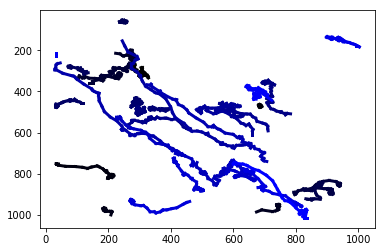

In [7]:
#%matplotlib notebook

frame_num = 61
is_one = False

currentX = X[:,:,0]
currentY = X[:,:,1]
plot_trajectory_2D(frame_num,is_one,currentX,currentY)


In [ ]:
#%matplotlib notebook

z = np.array(range(0,61))
frame_num = 61
is_one = False

currentX = X[:,:,0]
currentY = X[:,:,1]
plot_trajectory_3D(frame_num,is_one,currentX,currentY,z)


### AR

#### State Space reduction

In [8]:
X_copy = X.copy()
X_copy = np.transpose(X_copy,(1,0,2))
X_copy = X_copy.reshape(X_copy.shape[0],X_copy.shape[1]*X_copy.shape[2])
X_copy = X_copy.T

#scaler = StandardScaler()
#X_copy = scaler.fit_transform(X_copy)
X_copy = normalize(X_copy)
print (X_copy.shape)

(68, 61)


In [ ]:
# If needed, plot again
tt2 =  X_copy.T.copy()
tt2 = tt2.reshape(61,34,2)
tt2 = np.transpose(tt2,(1,0,2))

#Checking plot again after normalization
tt = tt2
frame_num = 61
is_one = False

currentX =tt[:,:,0]
currentY = tt[:,:,1]
plot_trajectory_2D(frame_num,is_one,currentX,currentY)


In [10]:
X_in,C,S,U = ar.state_space(X_copy, 5)
print (X_in.shape)
print (S)

(5, 61)
[[ 8.18225483  0.          0.          0.          0.        ]
 [ 0.          0.91363704  0.          0.          0.        ]
 [ 0.          0.          0.40119745  0.          0.        ]
 [ 0.          0.          0.          0.1332339   0.        ]
 [ 0.          0.          0.          0.          0.10440938]]


#### Histogram of components

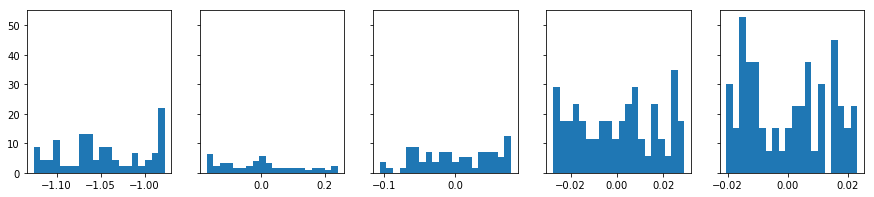

In [11]:
%matplotlib inline

X_in_copy = X_in.T.copy()
X_in0 = X_in_copy[:,0]
X_in1 = X_in_copy[:,1]
X_in2 = X_in_copy[:,2]
X_in3 = X_in_copy[:,3]
X_in4 = X_in_copy[:,4]


f, axarr = plt.subplots(1, 5,sharey=True,figsize=(15,3))

axarr[0].hist(X_in0, normed=True,bins=20)
axarr[1].hist(X_in1, normed=True,bins=20)
axarr[2].hist(X_in2, normed=True,bins=20)
axarr[3].hist(X_in3, normed=True,bins=20)
axarr[4].hist(X_in4, normed=True,bins=20)

plt.show()


#### Plotting components from PCA

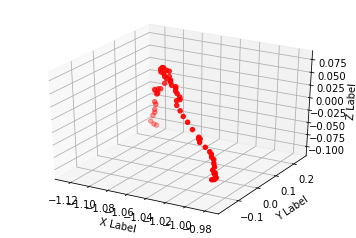

In [12]:
# 3D Plot

#matplotlib notebook

frame_num = X_in.shape[1]
single_flag = False
point_num = None

currentX = X_in[0,:]
currentY = X_in[1,:]
currentZ = X_in[2,:]

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =currentX
y =currentY
z =currentZ



ax.scatter(x, y, z,  c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

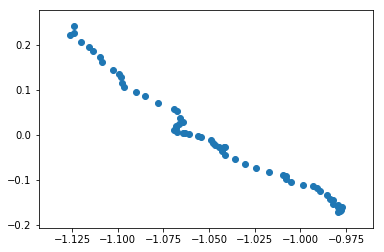

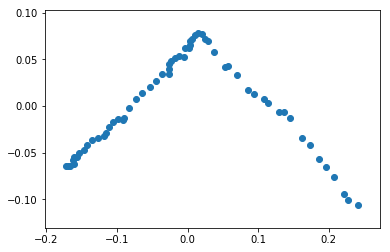

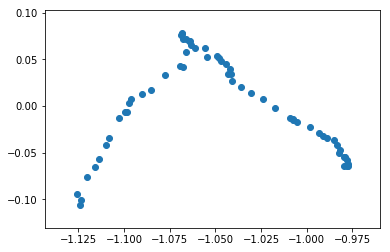

In [13]:
#2D Plot

plt.figure(0)
plt.scatter(X_in[0,:],X_in[1,:])


plt.figure(1)
plt.scatter(X_in[1,:],X_in[2,:])


plt.figure(2)
plt.scatter(X_in[0,:],X_in[2,:])

plt.show()


#### AR Train

In [14]:
A, Q = ar.train(X_in, order = 2)
A0,A1 = A[0],A[1]

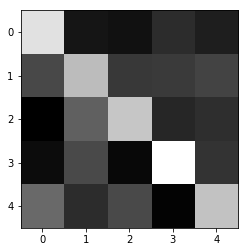

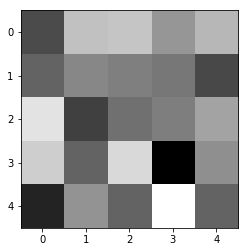

In [15]:
plt.figure(0)
plt.imshow(A0, cmap = "gray")
plt.figure(1)
plt.imshow(A1, cmap = "gray")
plt.show()

In [16]:
feature_vector = np.concatenate((A0.flatten(), A1.flatten()))
print(feature_vector)

[ 1.2903215  -0.16202032 -0.18781934  0.01180939 -0.09239067  0.20247272
  1.02843808  0.09949036  0.10512078  0.1650609  -0.3126506   0.37724225
  1.10108635 -0.03773974  0.01923238 -0.22423819  0.20840947 -0.25528429
  1.50952972  0.05111815  0.44580295  0.00497959  0.21179692 -0.28553382
  1.0731347  -0.29099215  0.17144727  0.18623114  0.00188307  0.1309657
 -0.19581619 -0.05375018 -0.08593394 -0.11866969 -0.30094052  0.30883583
 -0.33146378 -0.14282861 -0.09079728  0.05855518  0.22245389 -0.19418178
  0.26458839 -0.58387395 -0.02474775 -0.4443502  -0.00437673 -0.19558312
  0.41538919 -0.19426222]


#### Test AR

In [17]:
Y = ar.test(X_in, A0)
err = ar.error(Y,X_in)
np.mean(err)

0.20450924649711166

# MRS Videos

## Read Inputs

In [18]:
input_file_path = '/media/narita/Data/Neutrophils/fps_20_frames/2_07052016_Phagocytosis_MRS2578/final' \
                      '/tracking/organized_kalman_output_center_coords.npy'

mrsX1 = np.load(input_file_path)



In [19]:
input_file_path = '/media/narita/Data/Neutrophils/fps_20_frames/6_07072016_Phagocytosis_MRS2578/final' \
                      '/tracking/organized_kalman_output_center_coords.npy'

mrsX2 = np.load(input_file_path)



In [20]:
print (mrsX1.shape)
print (mrsX2.shape)

mrsX = np.vstack((mrsX1,mrsX2))
print (mrsX.shape)

(5, 61, 2)
(39, 61, 2)
(44, 61, 2)


### Trajectory Plots

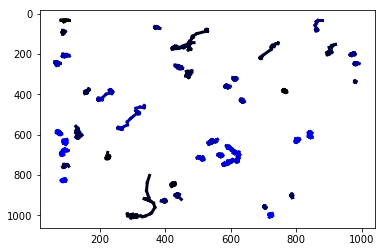

In [21]:
#%matplotlib notebook

frame_num = 61
is_one = False

currentX = mrsX[:,:,0]
currentY = mrsX[:,:,1]
plot_trajectory_2D(frame_num,is_one,currentX,currentY)


In [ ]:
#%matplotlib notebook

z = np.array(range(0,61))
frame_num = 61
is_one = False

currentX = mrsX[:,:,0]
currentY = mrsX[:,:,1]
plot_trajectory_3D(frame_num,is_one,currentX,currentY,z)


### AR

#### State Space

In [22]:
mrsX_copy = mrsX.copy()
mrsX_copy = np.transpose(mrsX_copy,(1,0,2))
mrsX_copy = mrsX_copy.reshape(mrsX_copy.shape[0],mrsX_copy.shape[1]*mrsX_copy.shape[2])
mrsX_copy = mrsX_copy.T
mrsX_copy = normalize(mrsX_copy)
print (mrsX_copy.shape)


(88, 61)


In [25]:
mrsX_in,C,S,U = ar.state_space(mrsX_copy, 5)
print (S)
print (mrsX_in.shape)

[[ 9.36769006  0.          0.          0.          0.        ]
 [ 0.          0.38354025  0.          0.          0.        ]
 [ 0.          0.          0.2629309   0.          0.        ]
 [ 0.          0.          0.          0.1094824   0.        ]
 [ 0.          0.          0.          0.          0.06262235]]
(5, 61)


#### Histograms of principal components

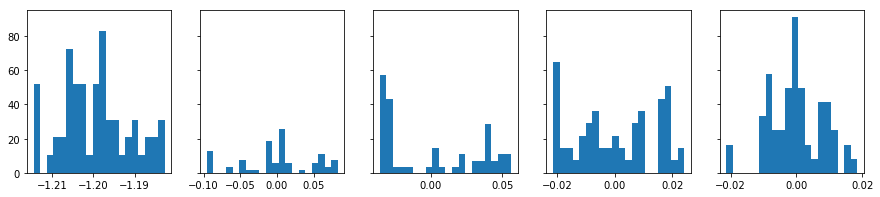

In [31]:
%matplotlib inline

mrsX_in_copy = mrsX_in.T.copy()
mrsX_in0 = mrsX_in_copy[:,0]
mrsX_in1 = mrsX_in_copy[:,1]
mrsX_in2 = mrsX_in_copy[:,2]
mrsX_in3 = mrsX_in_copy[:,3]
mrsX_in4 = mrsX_in_copy[:,4]

f, axarr = plt.subplots(1, 5,sharey=True,figsize=(15,3))
axarr[0].hist(mrsX_in0, normed=True,bins=20)
axarr[1].hist(mrsX_in1, normed=True,bins=20)
axarr[2].hist(mrsX_in2, normed=True,bins=20)
axarr[3].hist(mrsX_in3, normed=True,bins=20)
axarr[4].hist(mrsX_in4, normed=True,bins=20)

plt.show()


#### Plotting components after PCA

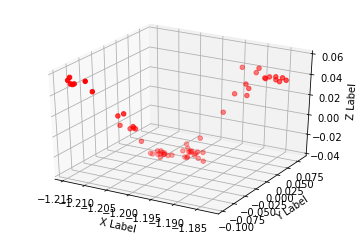

In [32]:
# 3D Plot
#%matplotlib notebook

frame_num = mrsX_in.shape[1]
single_flag = False
point_num = None

currentX = mrsX_in[0,:]
currentY = mrsX_in[1,:]
currentZ = mrsX_in[2,:]

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =currentX
y =currentY
z =currentZ



ax.scatter(x, y, z,  c='r', marker='o')


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

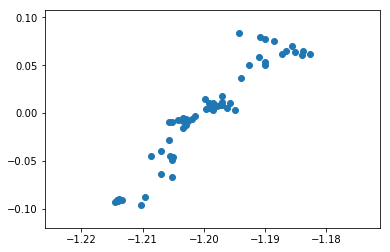

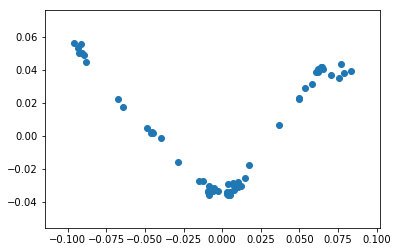

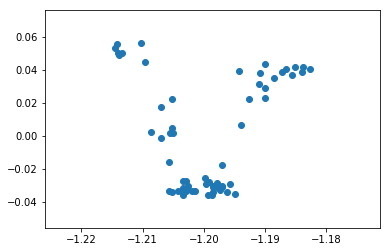

In [33]:
#2D Plot
plt.figure(0)
plt.scatter(mrsX_in[0,:],mrsX_in[1,:])

plt.figure(1)
plt.scatter(mrsX_in[1,:],mrsX_in[2,:])

plt.figure(2)
plt.scatter(mrsX_in[0,:],mrsX_in[2,:])

plt.show()

#### AR Train

In [34]:
A, Q = ar.train(mrsX_in, order = 2)
A0,A1 = A[0],A[1]

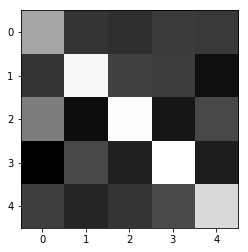

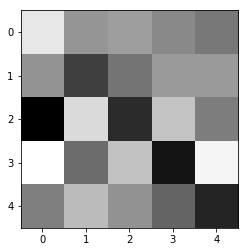

In [35]:
plt.figure(0)
plt.imshow(A0, cmap = "gray")
plt.figure(1)
plt.imshow(A1, cmap = "gray")

plt.show()

In [36]:
feature_vector = np.concatenate((A0.flatten(), A1.flatten()))
print(feature_vector)

[ 0.80907742  0.07365496  0.03857935  0.11663052  0.1073172   0.07743677
  1.35066586  0.16621662  0.13265966 -0.16780196  0.54753665 -0.18607509
  1.37775915 -0.12069348  0.19669702 -0.2685096   0.19977912 -0.05493604
  1.40252162 -0.07497334  0.14096356 -0.03194078  0.08304595  0.21704396
  1.15207546  0.19116858 -0.06979495 -0.04373376 -0.10907055 -0.16483731
 -0.07598011 -0.34541064 -0.17538877 -0.0550827  -0.05606467 -0.54727675
  0.14791565 -0.40724005  0.0770403  -0.1466227   0.26804371 -0.2029917
  0.07320268 -0.48308545  0.23601509 -0.14114498  0.04902211 -0.07973496
 -0.22630214 -0.42811863]


### AR Test

In [37]:
Y = ar.test(mrsX_in, A0)
err = ar.error(Y,mrsX_in)
np.mean(err)

0.26900107362778719

# Histograms of both

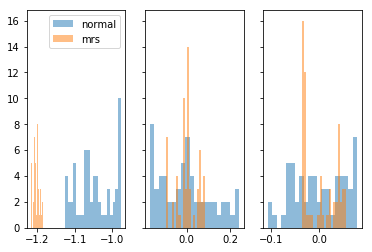

In [38]:
%matplotlib inline



f, axarr = plt.subplots(1, 3,sharey=True)

axarr[0].hist(X_in0, 20, alpha=0.5, label='normal')
axarr[0].hist(mrsX_in0, 20, alpha=0.5, label='mrs')
axarr[0].legend(loc='upper right')
#axarr[0].set_xlim([-5500,-4300])

axarr[1].hist(X_in1, 20, alpha=0.5, label='normal')
axarr[1].hist(mrsX_in1, 20, alpha=0.5, label='mrs')



axarr[2].hist(X_in2, 20, alpha=0.5, label='normal')
axarr[2].hist(mrsX_in2, 20, alpha=0.5, label='mrs')
#axarr[2].set_xlim([-350,200])

plt.show()
